# Voice Emotion Recognition

#### **Project Overview**

This Project provides a comprehensive analysis of the three models developed for voice emotion recognition.

Understanding their fundamental differences is key to evaluate the results and choosing the right approach for a given problem

## **Prepare the Dataset**

A crucial component of this project is the dataset. We need a corpus of audio recordings where each file is labeled with a specific emotion.
We used the **RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song)** dataset.

It's balanced, features multiple actors (male and female), and has clear emotional categories. The file naming convention makes it easy to extract the labels.

 We will focus on emotions like 'neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'.

### Download and Extract Dataset

In [3]:
import os
import zipfile
import requests
from tqdm import tqdm

In [2]:
# URL for the RAVDESS dataset (Audio_Speech_Actors_01-24.zip)
# This is a direct link to the dataset hosted on Zenodo.
file_url = "https://zenodo.org/records/1188976/files/Audio_Speech_Actors_01-24.zip?download=1"
file_name = "Audio_Speech_Actors_01-24.zip"
extract_dir = "ravdess_data"

# Check if the dataset zip file already exists to avoid re-downloading
if not os.path.exists(file_name):
    print(f"Downloading {file_name}...")

    # Use requests to download the file with a progress bar
    try:
        response = requests.get(file_url, stream=True)
        response.raise_for_status()  # Raise an exception for bad status codes

        total_size_in_bytes = int(response.headers.get('content-length', 0))
        block_size = 1024  # 1 Kilobyte

        progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)

        with open(file_name, 'wb') as file:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                file.write(data)

        progress_bar.close()

        if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
            print("ERROR, something went wrong during download.")
        else:
            print(f"{file_name} downloaded successfully.")

    except requests.exceptions.RequestException as e:
        print(f"Error downloading file: {e}")
        # If download fails, exit or handle error appropriately
        # For this script, we'll print the error and stop.
        exit()
else:
    print(f"{file_name} already exists. Skipping download.")

Audio_Speech_Actors_01-24.zip already exists. Skipping download.


In [3]:
file_name = "Audio_Speech_Actors_01-24.zip"
extract_dir = "ravdess_data"
# Check if the extraction directory already exists to avoid re-extracting
if not os.path.exists(extract_dir):
    print(f"\nExtracting {file_name} to {extract_dir}/...")
    try:
        with zipfile.ZipFile(file_name, 'r') as zip_ref:
            # Use tqdm to show extraction progress
            for member in tqdm(zip_ref.infolist(), desc='Extracting '):
                zip_ref.extract(member, extract_dir)
        print(f"Extraction complete. Dataset is in the '{extract_dir}' directory.")
    except zipfile.BadZipFile:
        print(f"Error: The downloaded file '{file_name}' is not a valid zip file or is corrupted.")
    except Exception as e:
        print(f"An error occurred during extraction: {e}")
else:
    print(f"Directory '{extract_dir}' already exists. Skipping extraction.")

# --- Verification Step ---
# Briefly check the contents to ensure extraction was successful.
try:
    # The extracted data contains subdirectories like 'Actor_01', 'Actor_02', etc.
    actor_dirs = [d for d in os.listdir(extract_dir) if os.path.isdir(os.path.join(extract_dir, d))]
    if actor_dirs:
        print(f"\nVerification successful: Found {len(actor_dirs)} actor directories.")
        print(f"Example directory: {os.path.join(extract_dir, actor_dirs[0])}")
    else:
        # This case handles if the zip extracts into an intermediate folder.
        # e.g., ravdess_data/Audio_Speech_Actors_01-24/Actor_01
        sub_dirs = [d for d in os.listdir(extract_dir)]
        if len(sub_dirs) == 1 and os.path.isdir(os.path.join(extract_dir, sub_dirs[0])):
             print(f"\nVerification successful: Data is nested in '{sub_dirs[0]}'.")
        else:
            print("\nVerification Warning: The directory structure is not as expected. Please check the contents of the 'ravdess_data' folder.")

except FileNotFoundError:
    print(f"\nVerification Failed: The directory '{extract_dir}' was not found. Extraction may have failed.")


Directory 'ravdess_data' already exists. Skipping extraction.

Verification successful: Found 24 actor directories.
Example directory: ravdess_data\Actor_01


## **Voice Emotion Recognition using CNN and LSTM**

Automatic Representation Learning: Treats audio as an "image" (spectrogram) and learns relevant features and their temporal patterns automatically.



*   Feature Engineering: Almost none. The model's primary strength is that it learns the features itself. The CNN layers act as sophisticated, trainable feature extractors.

*   Data Representation: The raw audio is converted into a 2D MFCC spectrogram ((time_steps, n_mfcc)). The entire sequence is preserved and fed into the model as a single tensor ((samples, height, width, channels)).

In [2]:
import numpy as np
import os
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
    BatchNormalization, TimeDistributed, LSTM
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tqdm import tqdm
import matplotlib.pyplot as plt

c:\Users\user\.conda\envs\dsp\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [1]:

import google.protobuf
print(google.protobuf.__version__)


3.20.3


In [21]:
from utils import *

### **DATA PREPROCESSING & FEATURE EXTRACTION**

In [5]:
# --- Configuration ---
# Define the path to the dataset directory
base_data_path = "ravdess_data"
if not os.path.exists(os.path.join(base_data_path, "Actor_01")):
    # If Actor_01 is not directly in ravdess_data, it's likely in a subdirectory
    sub_dirs = [d for d in os.listdir(base_data_path) if os.path.isdir(os.path.join(base_data_path, d))]
    if sub_dirs:
        data_path = os.path.join(base_data_path, sub_dirs[0])
    else:
        print("Error: Could not find actor directories in 'ravdess_data'.")
        exit()
else:
    data_path = base_data_path

# Define parameters for MFCC extraction
# We need a fixed shape for the input of the neural network.
# We'll pad or truncate the MFCC features to this size.
MAX_PAD_LEN = 174

# --- Emotion Mapping ---
# The RAVDESS filenames have a specific structure. The 3rd element (1-based) indicates the emotion.
# 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}
# We will focus on these emotions
observed_emotions = list(emotions.values())

# --- Feature Extraction Function ---
# def extract_features(file_path):
#     """
#     Extracts MFCCs from an audio file.
#     Pads or truncates the result to a fixed length (MAX_PAD_LEN).
#     """
#     try:
#         # Load the audio file
#         audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')

#         # Extract MFCCs
#         mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)

#         # Pad or truncate the MFCCs
#         pad_width = MAX_PAD_LEN - mfccs.shape[1]
#         if pad_width > 0:
#             # If the sequence is shorter, pad it with zeros
#             mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
#         else:
#             # If the sequence is longer, truncate it
#             mfccs = mfccs[:, :MAX_PAD_LEN]

#     except Exception as e:
#         print(f"Error processing {file_path}: {e}")
#         return None

#     return mfccs


In [6]:
# Main Processing Loop
features = []
labels = []

print("Starting feature extraction...")
# Iterate through each actor's directory
actor_dirs = sorted(os.listdir(data_path))
for actor_dir in tqdm(actor_dirs, desc="Processing Actors"):
    actor_path = os.path.join(data_path, actor_dir)
    if os.path.isdir(actor_path):
        # Iterate through each audio file for the actor
        for file_name in os.listdir(actor_path):
            try:
                # Parse the filename to get the emotion label
                emotion_code = file_name.split('-')[2]
                emotion = emotions.get(emotion_code)

                if emotion in observed_emotions:
                    file_path = os.path.join(actor_path, file_name)
                    
                    # 1. Load the audio file once
                    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')

                    # Extract features
                    data = extract_features(audio,sample_rate)
                    if data is not None:
                        features.append(data)
                        labels.append(emotion)
            except IndexError:
                # Handle filenames that don't match the expected format
                # print(f"Skipping file with unexpected name format: {file_name}")
                continue

print("Feature extraction completed.")

Starting feature extraction...


Processing Actors: 100%|██████████| 24/24 [01:05<00:00,  2.72s/it]

Feature extraction completed.


In [7]:
# --- Data Conversion and Encoding ---
# Convert lists to NumPy arrays
X = np.array(features)
y = np.array(labels)

# Encode the string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode the integer labels
# This is necessary for categorical_crossentropy loss function
y_one_hot = to_categorical(y_encoded)

# --- Save Processed Data ---
# Saving the processed data allows us to skip the extraction phase in the future
output_dir = "processed_data"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

np.save(os.path.join(output_dir, 'X_features.npy'), X)
np.save(os.path.join(output_dir, 'y_labels.npy'), y_one_hot)
# Also save the label encoder to be able to decode predictions later
np.save(os.path.join(output_dir, 'label_encoder.npy'), label_encoder.classes_)


print("\n--- Data Processing Summary ---")
print(f"Total samples processed: {len(X)}")
print(f"Features array shape (X): {X.shape}")
print(f"Labels array shape (y): {y_one_hot.shape}")
print(f"Data saved to '{output_dir}' directory.")


--- Data Processing Summary ---
Total samples processed: 1440
Features array shape (X): (1440, 40, 174)
Labels array shape (y): (1440, 8)
Data saved to 'processed_data' directory.


In [8]:
#Step 1: Load the Preprocessed Data

print("Loading preprocessed data...")
data_dir = "processed_data"
try:
    X = np.load(os.path.join(data_dir, 'X_features.npy'))
    y = np.load(os.path.join(data_dir, 'y_labels.npy'))
    label_classes = np.load(os.path.join(data_dir, 'label_encoder.npy'), allow_pickle=True)
except FileNotFoundError:
    print("Error: Processed data files not found.")
    exit()

Loading preprocessed data...


In [9]:
#Step 2: Reshape Data for the Model
# The CNN expects a 4D input (batch, height, width, channels).
# Our MFCC data is (num_samples, n_mfcc, time_steps). We need to add a 'channels' dimension.
X = X[..., np.newaxis] # Adds a channel dimension, making it (num_samples, 40, 174, 1)

In [10]:
#Step 3: Split Data into Training and Testing Sets
# We'll use a standard 80/20 split.
# `stratify=y` ensures that the proportion of emotions is the same in train and test sets.
X_train, X_test_valid, y_train, y_test_valid = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)
X_test, X_valid, y_test, y_valid = train_test_split(
    X_test_valid, y_test_valid,
    test_size= 0.5,
    random_state=42,
    stratify=y_test_valid
)

print("\n--- Data Shapes ---")
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Validation data shape:", X_valid.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)
print("Validation labels shape:", y_valid.shape)
print(f"Number of classes: {len(label_classes)}")


--- Data Shapes ---
Training data shape: (1008, 40, 174, 1)
Testing data shape: (216, 40, 174, 1)
Validation data shape: (216, 40, 174, 1)
Training labels shape: (1008, 8)
Testing labels shape: (216, 8)
Validation labels shape: (216, 8)
Number of classes: 8


### Model Architetcture

1.   **Input:** Raw audio files categorized by emotion
2.   **Feature Extraction:** We will convert audio signals into a 2D representation: Mel-frequency Cepstral Coefficients (MFCCs). This process transforms the audio into an "image-like" format that a CNN can process, where one axis is time and the other is the Mel-frequency cepstrum.

3.   **CNN Layers:** The CNN will act as a feature extractor. It will scan the MFCC spectrograms and learn to identify spatial patterns (e.g., specific shapes and textures in the spectrogram) that are characteristic of different emotions.
4.    **LSTM Layer:** The output from the CNN (a sequence of feature maps over time) will be fed into an LSTM layer. The LSTM will analyze this sequence to learn the temporal dependencies—how the acoustic features evolve over the duration of an utterance—which is crucial for understanding emotional expression.
5.    **Output:** A classification layer (Dense with Softmax activation) will predict the probability of the audio belonging to one of several emotional categories (e.g., happy, sad, angry, neutral).

In [75]:
#Step 4: Define the CNN-LSTM Model Architecture
print("\nBuilding the CNN-LSTM model...")

# Get input shape and number of classes from the data
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

model = Sequential()

# CNN Part - Feature Extractor
# Layer 1
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
#model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Layer 2
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
#model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Layer 3
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
#model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Reshape for LSTM: The LSTM layer expects a sequence.
# We use TimeDistributed to apply layers to each time-slice of the CNN output.
# The output of the CNN part is a set of feature maps. We'll treat the width dimension as the "time" sequence for the LSTM.
# Current shape: (batch, height, width, channels) -> We need (batch, timesteps, features)
# We flatten the height and channel dimensions together.

shape = model.output_shape
model.add(tf.keras.layers.Reshape((shape[1] * shape[2], shape[3]), input_shape=shape))

#model.add(tf.keras.layers.Reshape((-1, 128)))

# LSTM Part - Temporal Analysis
#model.add(LSTM(128, return_sequences=False)) # return_sequences=False as it's the last LSTM layer
#model.add(Dropout(0.3))

model.add(LSTM(128, return_sequences=False, kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(1e-4)))


#model.add(Dense(num_classes, activation='softmax'))


Building the CNN-LSTM model...


In [76]:
# Step 5: Compile the Model

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 38, 172, 32)       320       
                                                                 
 batch_normalization_9 (Batc  (None, 38, 172, 32)      128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 19, 86, 32)       0         
 2D)                                                             


                                                                 
 dropout_12 (Dropout)        (None, 19, 86, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 17, 84, 64)        18496     
                                                                 
 batch_normalization_10 (Bat  (None, 17, 84, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 8, 42, 64)        0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 8, 42, 64)         0         
                                                                 
 conv2d_11 (Conv2D)          (None, 6, 40, 128)        73856     
                                                                 
 batch_nor

In [ ]:
#Step 6: Train the Model

print("\nStarting model training...")

# Callbacks for more control over training

# ModelCheckpoint saves the best model found during training.
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# EarlyStopping stops training if the validation loss doesn't improve for a number of epochs.
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20, # Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True,
    verbose=1
)

# Set training parameters
epochs = 40
batch_size = 32

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint, early_stopping]
)


Starting model training...
Epoch 1/40
32/32 [==============================] - ETA: 0s - loss: 2.0618 - accuracy: 0.1895
Epoch 1: val_accuracy improved from -inf to 0.16204, saving model to best_model.keras
32/32 [==============================] - 7s 158ms/step - loss: 2.0618 - accuracy: 0.1895 - val_loss: 2.2502 - val_accuracy: 0.1620
Epoch 2/40
32/32 [==============================] - ETA: 0s - loss: 1.8574 - accuracy: 0.2927
Epoch 2: val_accuracy improved from 0.16204 to 0.22685, saving model to best_model.keras
32/32 [==============================] - 4s 140ms/step - loss: 1.8574 - accuracy: 0.2927 - val_loss: 2.0539 - val_accuracy: 0.2269
Epoch 3/40
32/32 [==============================] - ETA: 0s - loss: 1.7682 - accuracy: 0.3403
Epoch 3: val_accuracy improved from 0.22685 to 0.23611, saving model to best_model.keras
32/32 [==============================] - 13s 406ms/step - loss: 1.7682 - accuracy: 0.3403 - val_loss: 1.8879 - val_accuracy: 0.2361
Epoch 4/40
32/32 [==============


Plotting training history...


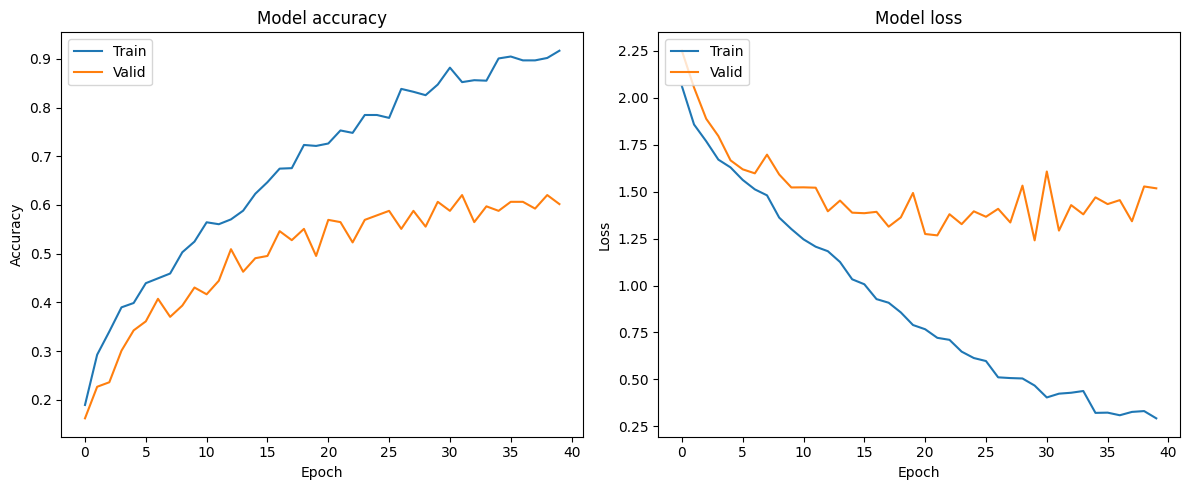


Training complete. The best model has been saved as 'best_model.keras'.


In [14]:
#Step 7: Plot Training History

print("\nPlotting training history...")
plot_history(history)

print("\nTraining complete. The best model has been saved as 'best_model.keras'.")

In [ ]:
# --- Step 2: Evaluate the Model on the Test Set ---
try:
    model = tf.keras.models.load_model('best_model.keras')
except (IOError, ImportError) as e:
    print("Error: Could not load the model 'best_model.keras'.")
    print("Please ensure the model was saved correctly .")
    print(f"Details: {e}")
    exit()
    
print("\nEvaluating the semplified model performance on the test set...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")


Evaluating the semplified model performance on the test set...
Test Accuracy: 57.41%
Test Loss: 1.5461



Generating predictions and confusion matrix...
7/7 [==============================] - 1s 43ms/step


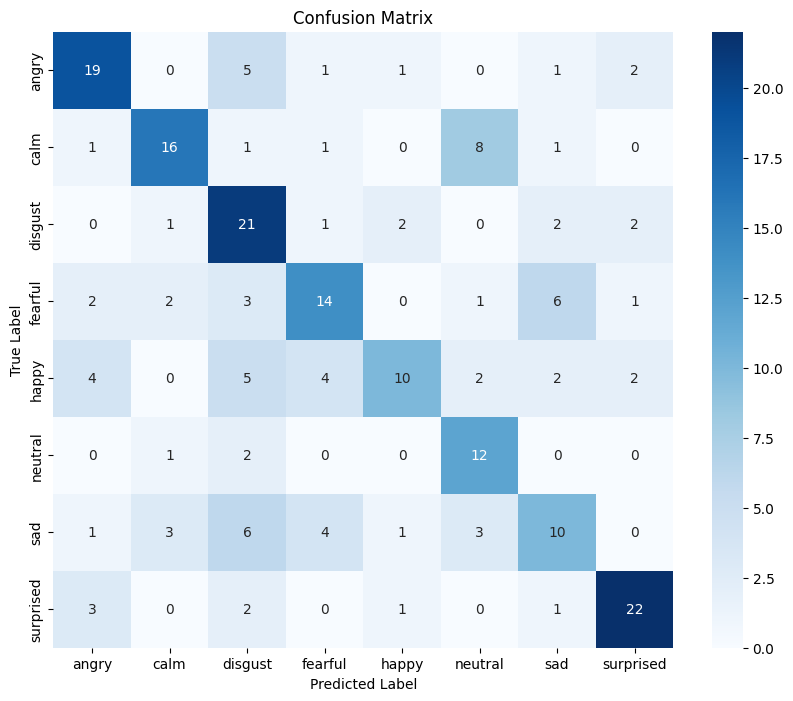

In [ ]:
# --- Step 3: Generate Predictions and Confusion Matrix ---
print("\nGenerating predictions and confusion matrix...")
plot_Confusion_matrix(model,X_test,y_test,label_classes)


## Data Augmentation

In [18]:
def add_noise(audio, noise_factor=0.005):
    """Adds random noise to an audio signal."""
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    # Cast back to same data type
    augmented_audio = augmented_audio.astype(type(audio[0]))
    return augmented_audio

def shift_time(audio, sample_rate, shift_max_sec=0.2):
    """Shifts the audio in time by a random amount."""
    shift_samples = int(np.random.rand() * shift_max_sec * sample_rate)
    return np.roll(audio, shift_samples)

def change_pitch(audio, sample_rate, pitch_factor=2):
    """Changes the pitch of the audio."""
    return librosa.effects.pitch_shift(y=audio, sr=sample_rate, n_steps=pitch_factor)

In [19]:
data_path = "ravdess_data"
actor_dirs = sorted(os.listdir(data_path))
num_actors = len(actor_dirs)

# Example: use first 18 actors for training,3 for validation and last 3 for testing
train_actors = actor_dirs[:18]
val_actors = actor_dirs[18:21]
test_actors = actor_dirs[21:]

In [ ]:

#UPDATED Main Processing Loop with Augmentation 
X_train_aug = []
y_train_aug = []

print("Starting feature extraction with augmentation on training data only...")

actor_dirs = sorted(os.listdir(data_path))

for actor_dir in tqdm(train_actors, desc="Processing Actors"):
    actor_path = os.path.join(data_path, actor_dir)
    if not os.path.isdir(actor_path):
        continue

    for file_name in os.listdir(actor_path):
        try:
            emotion_code = file_name.split('-')[2]
            emotion = emotions.get(emotion_code)

            if emotion in observed_emotions:
                file_path = os.path.join(actor_path, file_name)
                
                # 1. Load the audio file once
                audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')

                # 2. Process ORIGINAL audio
                original_data = extract_features(audio, sample_rate)
                if original_data is not None:
                    X_train_aug.append(original_data)
                    y_train_aug.append(emotion)

                # 3. Process AUGMENTED audio (Noise)
                noisy_audio = add_noise(audio)
                noisy_data = extract_features(noisy_audio, sample_rate)
                if noisy_data is not None:
                    X_train_aug.append(noisy_data)
                    y_train_aug.append(emotion)
                
                # 4. Process AUGMENTED audio (Pitch Shift)
                # Use different pitch factors for variety
                pitched_audio = change_pitch(audio, sample_rate, pitch_factor=np.random.randint(-3, 4))
                pitched_data = extract_features(pitched_audio, sample_rate)
                if pitched_data is not None:
                    X_train_aug.append(pitched_data)
                    y_train_aug.append(emotion)

        except Exception as e:
            # print(f"Skipping file {file_name} due to error: {e}")
            continue

print(f"Feature extraction completed. Total samples: {len(X_train_aug)}")


Starting feature extraction with augmentation on training data only...


Processing Actors: 100%|██████████| 18/18 [01:35<00:00,  5.30s/it]

Feature extraction completed. Total samples: 3240


In [22]:

# Main Processing Loop
X_valid_aug = []
y_valid_aug = []


print("Starting feature extraction for validation and test ...")
# Iterate through each actor's directory
actor_dirs = sorted(os.listdir(data_path))

for actor_dir in tqdm(val_actors, desc="Processing Actors"):
    actor_path = os.path.join(data_path, actor_dir)
    if os.path.isdir(actor_path):
        # Iterate through each audio file for the actor
        for file_name in os.listdir(actor_path):
            try:
                # Parse the filename to get the emotion label
                emotion_code = file_name.split('-')[2]
                emotion = emotions.get(emotion_code)

                if emotion in observed_emotions:
                    file_path = os.path.join(actor_path, file_name)
                    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
                    # Extract features
                    data = extract_features(audio, sample_rate)
                    if data is not None:
                        X_valid_aug.append(data)
                        y_valid_aug.append(emotion)
            except IndexError:
                # Handle filenames that don't match the expected format
                # print(f"Skipping file with unexpected name format: {file_name}")
                continue
            
            
X_test_aug = []
y_test_aug = []
           
actor_dirs = sorted(os.listdir(data_path))
for actor_dir in tqdm(test_actors, desc="Processing Actors"):
    actor_path = os.path.join(data_path, actor_dir)
    if os.path.isdir(actor_path):
        # Iterate through each audio file for the actor
        for file_name in os.listdir(actor_path):
            try:
                # Parse the filename to get the emotion label
                emotion_code = file_name.split('-')[2]
                emotion = emotions.get(emotion_code)

                if emotion in observed_emotions:
                    file_path = os.path.join(actor_path, file_name)
                    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
                    
                    # Extract features
                    data = extract_features(audio, sample_rate)
                    if data is not None:
                        X_test_aug.append(data)
                        y_test_aug.append(emotion)
            except IndexError:
                # Handle filenames that don't match the expected format
                # print(f"Skipping file with unexpected name format: {file_name}")
                continue

print("Feature extraction completed.")

Starting feature extraction for validation and test ...


Processing Actors: 100%|██████████| 3/3 [00:07<00:00,  2.63s/it]

Feature extraction completed.


In [23]:
# Convert lists to NumPy arrays
X_train_np = np.array(X_train_aug)
y_train_np = np.array(y_train_aug)
X_test_np = np.array(X_test_aug)
y_test_np = np.array(y_test_aug)
X_valid_np = np.array(X_valid_aug)
y_valid_np = np.array(y_valid_aug)

# Encode the string labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_np)
y_test_encoded = label_encoder.fit_transform(y_test_np)
y_valid_encoded = label_encoder.fit_transform(y_valid_np)
# One-hot encode the integer labels
# This is necessary for categorical_crossentropy loss function
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)
y_valid_one_hot = to_categorical(y_valid_encoded)

# --- Save Processed Data ---
# Saving the processed data allows us to skip the extraction phase in the future
output_dir = "aug_processed_data"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

np.save(os.path.join(output_dir, 'X_train.npy'), X_train_np)
np.save(os.path.join(output_dir, 'y_train.npy'), y_train_one_hot)
np.save(os.path.join(output_dir, 'X_test.npy'), X_test_np)
np.save(os.path.join(output_dir, 'y_test.npy'), y_test_one_hot)
np.save(os.path.join(output_dir, 'X_valid.npy'), X_valid_np)
np.save(os.path.join(output_dir, 'y_valid.npy'), y_valid_one_hot)
# Also save the label encoder to be able to decode predictions later
np.save(os.path.join(output_dir, 'label_encoder.npy'), label_encoder.classes_)

In [31]:
#Step 1: Load the Preprocessed Data

print("Loading preprocessed data...")
data_dir = "aug_processed_data"
try:
    X_train_aug = np.load(os.path.join(data_dir, 'X_train.npy'))
    y_train_aug = np.load(os.path.join(data_dir, 'y_train.npy'))
    X_test_aug = np.load(os.path.join(data_dir, 'X_test.npy'))
    y_test_aug = np.load(os.path.join(data_dir, 'y_test.npy'))
    X_valid_aug = np.load(os.path.join(data_dir, 'X_valid.npy'))
    y_valid_aug = np.load(os.path.join(data_dir, 'y_valid.npy'))
    label_classes = np.load(os.path.join(data_dir, 'label_encoder.npy'), allow_pickle=True)
except FileNotFoundError:
    print("Error: Processed data files not found.")
    exit()

Loading preprocessed data...


In [33]:
#Step 2: Reshape Data for the Model
# The CNN expects a 4D input (batch, height, width, channels).
# Our MFCC data is (num_samples, n_mfcc, time_steps). We need to add a 'channels' dimension.

X_train_aug = X_train_aug[..., np.newaxis] # Adds a channel dimension, making it (num_samples, 40, 174, 1)
X_test_aug = X_test_aug[..., np.newaxis]
X_valid_aug = X_valid_aug[..., np.newaxis]

In [77]:
#Step 3: Split Data into Training and Testing Sets
print("\n--- Data Shapes ---")
print("Training data shape:", X_train_aug.shape)
print("Testing data shape:", X_test_aug.shape)
print("Validation data shape:", X_valid_aug.shape)
print("Training labels shape:", y_train_aug.shape)
print("Testing labels shape:", y_test_aug.shape)
print("Validation labels shape:", y_valid_aug.shape)
print(f"Number of classes: {len(label_classes)}")


--- Data Shapes ---
Training data shape: (3240, 40, 174, 1)
Testing data shape: (180, 40, 174, 1)
Validation data shape: (180, 40, 174, 1)
Training labels shape: (3240, 8)
Testing labels shape: (180, 8)
Validation labels shape: (180, 8)
Number of classes: 8


In [40]:
X_train_aug = X_train_aug / np.max(X_train_aug)
X_test_aug = X_test_aug / np.max(X_test_aug)
X_valid_aug = X_valid_aug / np.max(X_valid_aug)

In [ ]:
aug_history = model.fit(
    X_train_aug, y_train_aug,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_valid_aug, y_valid_aug),
    callbacks=[checkpoint,early_stopping]
)

Epoch 1/40
102/102 [==============================] - ETA: 0s - loss: 0.4710 - accuracy: 0.8448
Epoch 1: val_accuracy did not improve from 0.74444
102/102 [==============================] - 14s 140ms/step - loss: 0.4710 - accuracy: 0.8448 - val_loss: 2.6432 - val_accuracy: 0.3778
Epoch 2/40
102/102 [==============================] - ETA: 0s - loss: 0.5240 - accuracy: 0.8269
Epoch 2: val_accuracy did not improve from 0.74444
102/102 [==============================] - 15s 146ms/step - loss: 0.5240 - accuracy: 0.8269 - val_loss: 3.2451 - val_accuracy: 0.2889
Epoch 3/40
102/102 [==============================] - ETA: 0s - loss: 0.4973 - accuracy: 0.8336
Epoch 3: val_accuracy did not improve from 0.74444
102/102 [==============================] - 15s 143ms/step - loss: 0.4973 - accuracy: 0.8336 - val_loss: 2.5158 - val_accuracy: 0.4111
Epoch 4/40
102/102 [==============================] - ETA: 0s - loss: 0.4507 - accuracy: 0.8571
Epoch 4: val_accuracy did not improve from 0.74444
102/102 [=


Plotting training history...


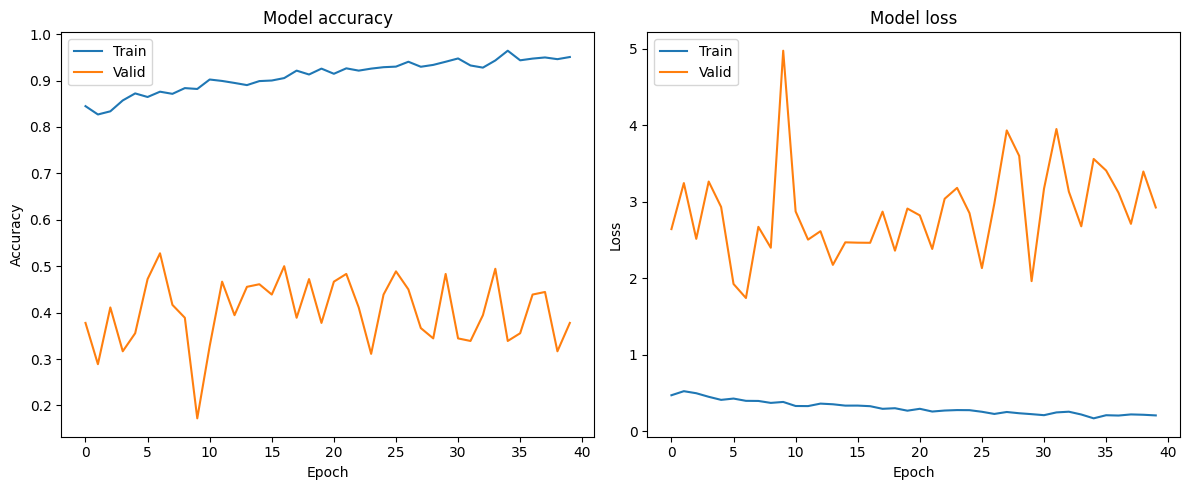


Training complete. The best model has been saved as 'best_model.keras'.


In [ ]:
#Step 7: Plot Training History
print("\nPlotting training history...")
plot_history(aug_history)
print("\nTraining complete. The best model has been saved as 'best_model.keras'.")

In [48]:
#: Evaluate the Model on the Test Set ---
try:
    aug_model = tf.keras.models.load_model('best_model.keras')
except (IOError, ImportError) as e:
    print("Error: Could not load the model 'best_model.keras'.")
    print("Please ensure the model was saved correctly in Phase 3.")
    print(f"Details: {e}")
    exit()
print("\nEvaluating the semplified model performance on the test set...")
loss, accuracy = aug_model.evaluate(X_test_aug, y_test_aug, verbose=0)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")


Evaluating the semplified model performance on the test set...
Test Accuracy: 13.33%
Test Loss: 5.7594



Generating predictions and confusion matrix...
7/7 [==============================] - 1s 60ms/step


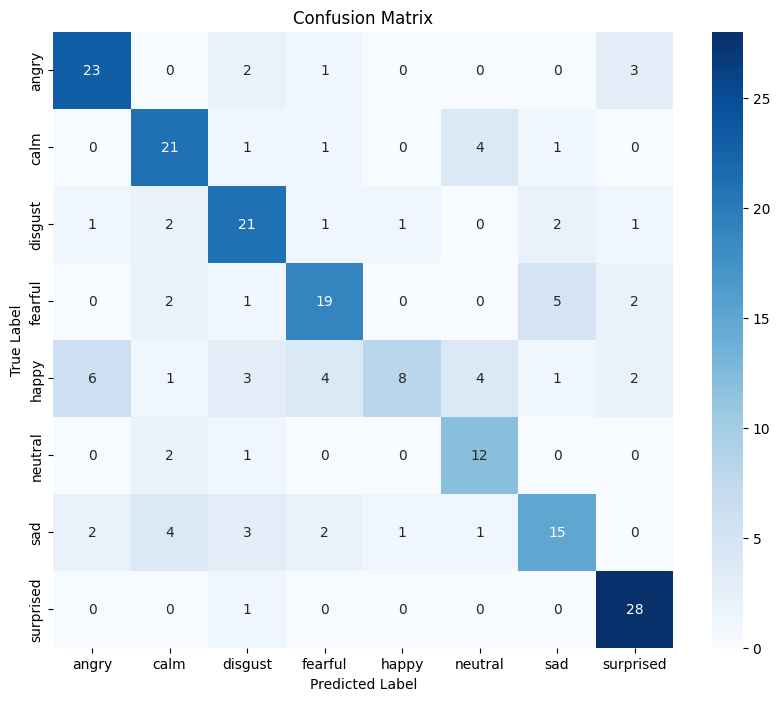

In [ ]:
# --- Step 3: Generate Predictions and Confusion Matrix ---
print("\nGenerating predictions and confusion matrix...")
plot_Confusion_matrix(aug_model,X_test,y_test,label_classes)

### test

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout,
    Reshape, LSTM, Attention, Dense, GlobalAveragePooling1D ) 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def build_refined_model(input_shape, num_classes):
    """
    Builds a refined CNN-LSTM model with an Attention layer and increased regularization.
    """
    inputs = Input(shape=input_shape)

    # --- CNN Feature Extractor ---
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)

    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)

    x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)

    # --- Reshape for LSTM ---
    shape = x.shape
    x = Reshape((shape[1] * shape[2], shape[3]))(x)

    # --- LSTM with Attention ---
    lstm_out = LSTM(128, return_sequences=True, kernel_regularizer=l2(2e-4))(x)
    
    attention_result = Attention()([lstm_out, lstm_out])
    
    # NEW: Add a pooling layer to aggregate the sequence from the attention layer
    # This reduces the shape from (None, 60, 128) to (None, 128)
    x = GlobalAveragePooling1D()(attention_result)
    
    x = Dropout(0.5)(x)
    
    # --- Output Layer ---
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(2e-4))(x)

    # --- Build and Compile Model ---
    model = Model(inputs=inputs, outputs=outputs)
    
    optimizer = Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [94]:
X_train_aug.shape

(3240, 40, 174, 1)

In [101]:
# --- 1. Define Model Parameters ---
# (Assuming your augmented data X_train_aug, y_train_aug, etc. are loaded)
input_shape = X_train_aug.shape[1:]
num_classes = y_train_aug.shape[1]

# --- 2. Build the Refined Model ---
print("Building the refined CNN-LSTM model with Attention...")
refined_model = build_refined_model(input_shape, num_classes)
refined_model.summary()

# --- 3. Define Callbacks for Robust Training ---
# ModelCheckpoint saves the best model found during training
checkpoint = ModelCheckpoint(
    'best_refined_model.keras',  # New filename for the improved model
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# EarlyStopping stops training if validation performance doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15, # Increased patience to work with the learning rate scheduler
    restore_best_weights=True,
    verbose=1
)

# NEW: ReduceLROnPlateau reduces the learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Reduce learning rate by a factor of 5
    patience=5, # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6, # Lower bound on the learning rate
    verbose=1
)

# --- 4. Set Training Parameters ---
epochs = 40 # Increased epochs since EarlyStopping will handle the end of training
batch_size = 32



Building the refined CNN-LSTM model with Attention...
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 40, 174, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 38, 172, 32)  320         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_21 (BatchN  (None, 38, 172, 32)  128        ['conv2d_21[0][0]']              
 ormalization)                                                                                    
                                      

In [102]:
# --- 5. Train the Model ---
print("\nStarting model training with augmented data and refined architecture...")
history_refined = refined_model.fit(
    X_train_aug, y_train_aug,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_valid_aug, y_valid_aug),
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

print("\nTraining complete. The best refined model has been saved.")


Starting model training with augmented data and refined architecture...
Epoch 1/40
102/102 [==============================] - ETA: 0s - loss: 1.9719 - accuracy: 0.2367
Epoch 1: val_accuracy improved from -inf to 0.13333, saving model to best_refined_model.keras
102/102 [==============================] - 36s 311ms/step - loss: 1.9719 - accuracy: 0.2367 - val_loss: 3.2047 - val_accuracy: 0.1333 - lr: 0.0010
Epoch 2/40
102/102 [==============================] - ETA: 0s - loss: 1.7547 - accuracy: 0.3349
Epoch 2: val_accuracy did not improve from 0.13333
102/102 [==============================] - 44s 433ms/step - loss: 1.7547 - accuracy: 0.3349 - val_loss: 3.2119 - val_accuracy: 0.1333 - lr: 0.0010
Epoch 3/40
102/102 [==============================] - ETA: 0s - loss: 1.5813 - accuracy: 0.4130
Epoch 3: val_accuracy did not improve from 0.13333
102/102 [==============================] - 44s 428ms/step - loss: 1.5813 - accuracy: 0.4130 - val_loss: 3.2944 - val_accuracy: 0.0667 - lr: 0.0010
Ep


Plotting training history...


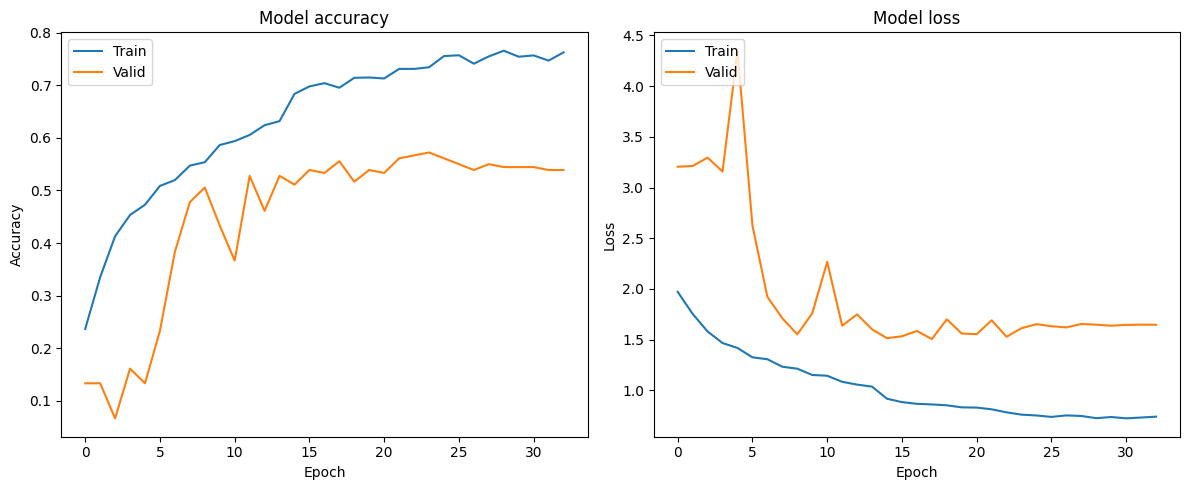


Training complete. The best model has been saved as 'best_model.keras'.


In [103]:
#Step 7: Plot Training History
print("\nPlotting training history...")
plot_history(history_refined)
print("\nTraining complete. The best model has been saved as 'best_model.keras'.")

In [104]:
#: Evaluate the Model on the Test Set ---
try:
    ref_model = tf.keras.models.load_model('best_refined_model.keras')
except (IOError, ImportError) as e:
    print("Error: Could not load the model 'best_refined_model.keras'.")
    print("Please ensure the model was saved correctly in Phase 3.")
    print(f"Details: {e}")
    exit()
print("\nEvaluating the semplified model performance on the test set...")
loss, accuracy = ref_model.evaluate(X_test_aug, y_test_aug, verbose=0)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")


Evaluating the semplified model performance on the test set...
Test Accuracy: 60.56%
Test Loss: 1.1720


### Adding more dataset 

In [32]:
import os
import zipfile
from tqdm import tqdm

# --- Configuration for SAVEE Dataset ---
file_name = "archive.zip" 
extract_dir = "savee_data"

# --- Extract the Dataset ---
if not os.path.exists(extract_dir):
    print(f"\nExtracting {file_name} to {extract_dir}/...")
    try:
        with zipfile.ZipFile(file_name, 'r') as zip_ref:
            for member in tqdm(zip_ref.infolist(), desc='Extracting SAVEE'):
                zip_ref.extract(member, extract_dir)
        print(f"Extraction complete. Dataset is in '{extract_dir}'.")
    except FileNotFoundError:
        print(f"ERROR: '{file_name}' not found. Please make sure you have downloaded it and the filename is correct.")
    except Exception as e:
        print(f"An error occurred during extraction: {e}")
else:
    print(f"Directory '{extract_dir}' already exists. Skipping extraction.")

# --- Corrected Verification Step ---
try:
    extracted_contents = os.listdir(extract_dir)
    print(f"\nVerification successful. Contents of '{extract_dir}': {extracted_contents}")
    
    # CORRECTED: Look for the 'ALL' folder instead of 'AudioData'
    emotion_files_path = os.path.join(extract_dir, 'ALL') 
    
    # List the first 5 files as an example
    files_in_all_folder = os.listdir(emotion_files_path)[:5]
    print(f"Found audio files inside 'ALL', for example: {files_in_all_folder}")
except Exception as e:
    print(f"\nVerification Failed: {e}")


Extracting archive.zip to savee_data/...


Extracting SAVEE: 100%|██████████| 480/480 [00:01<00:00, 364.10it/s]

Extraction complete. Dataset is in 'savee_data'.

Verification successful. Contents of 'savee_data': ['ALL']
Found audio files inside 'ALL', for example: ['DC_a01.wav', 'DC_a02.wav', 'DC_a03.wav', 'DC_a04.wav', 'DC_a05.wav']


In [35]:
import os
import glob
import librosa
import numpy as np
from tqdm import tqdm
import re # <-- Import the regular expression module

# --- Configuration from your notebook ---
MAX_PAD_LEN = 174

def extract_features(audio, sample_rate):
    """Extracts MFCCs from an audio file and pads/truncates them."""
    try:
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = MAX_PAD_LEN - mfccs.shape[1]
        if pad_width > 0:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :MAX_PAD_LEN]
    except Exception as e:
        print(f"Error processing file: {e}")
        return None
    return mfccs

# --- SAVEE Emotion Mapping ---
savee_emotions = {
    'a': 'angry', 'd': 'disgust', 'f': 'fearful',
    'h': 'happy', 'n': 'neutral', 'sa': 'sad', 'su': 'surprised'
}

# --- Corrected Processing Loop for SAVEE ---
savee_data_path = os.path.join("savee_data", "ALL") 
X_savee, y_savee = [], []

all_files = glob.glob(os.path.join(savee_data_path, "*.wav"))

print("Processing SAVEE dataset...")
for file_path in tqdm(all_files, desc="Processing SAVEE files"):
    file_name = os.path.basename(file_path)
    
    # CORRECTED: Use regex to accurately extract the emotion code (e.g., 'a' or 'sa')
    emotion_code = re.match(r'([a-zA-Z]+)', file_name.split('_')[1]).group(1)
    
    emotion = savee_emotions.get(emotion_code)

    if emotion:
        try:
            audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
            features = extract_features(audio, sample_rate)
            if features is not None:
                X_savee.append(features)
                y_savee.append(emotion)
        except Exception as e:
            print(f"Error processing {file_name}: {e}")
            continue

print(f"SAVEE processing complete. Found {len(X_savee)} samples.")

Processing SAVEE dataset...


Processing SAVEE files: 100%|██████████| 480/480 [00:21<00:00, 22.15it/s]

SAVEE processing complete. Found 480 samples.


In [14]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import pandas as pd

# --- 1. Load your original processed RAVDESS data ---
# This assumes you have the 'processed_data' folder from your first run
X_ravdess = np.load('processed_data/X_features.npy')
y_ravdess_one_hot = np.load('processed_data/y_labels.npy')
label_classes_ravdess = np.load('processed_data/label_encoder.npy', allow_pickle=True)

# Decode one-hot encoded labels back to strings
y_ravdess = [label_classes_ravdess[np.argmax(y)] for y in y_ravdess_one_hot]

# --- 2. Filter out the 'calm' emotion from RAVDESS ---
ravdess_df = pd.DataFrame({'features': list(X_ravdess), 'labels': y_ravdess})
ravdess_df_filtered = ravdess_df[ravdess_df['labels'] != 'calm'].copy()

# CORRECTED: Keep RAVDESS features as a list for now
X_ravdess_filtered = ravdess_df_filtered['features'].tolist()
y_ravdess_filtered = ravdess_df_filtered['labels'].tolist()

In [15]:
# --- 3. Combine RAVDESS and SAVEE data ---
# CORRECTED: Combine the Python lists first
X_combined_list = X_ravdess_filtered + X_savee
y_combined = y_ravdess_filtered + y_savee

# CORRECTED: Convert the final combined list to a single NumPy array
X_combined = np.array(X_combined_list)
# --- 4. Encode the combined labels ---
# We now have 7 emotions
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_combined)
y_one_hot = to_categorical(y_encoded)
num_classes = len(label_encoder.classes_)

# Save the new encoder for later use
np.save('combined_label_encoder.npy', label_encoder.classes_)
print(f"\nCombined dataset has {num_classes} classes: {label_encoder.classes_}")

# --- 5. Create Final Speaker-Independent Sets ---
# We need to assign speakers to sets. RAVDESS has 24 speakers, SAVEE has 4.
# RAVDESS speakers are identified by their actor number (e.g., 'Actor_01', 'Actor_24')
# SAVEE speakers are identified by initials ('DC', 'JE', 'JK', 'KL')

# Let's create a speaker ID list that matches our combined data
# RAVDESS speaker IDs (actors are 1-based, files are ordered by actor)
ravdess_speaker_ids = []
for i in range(1, 25):
    # Each actor has 60 files, but we filtered 'calm' (8 files per actor)
    # So now each actor has 52 files
    ravdess_speaker_ids.extend([f'ravdess_{i}'] * 52) 
    
# SAVEE speaker IDs (from filenames like 'DC_a01.wav')
savee_speaker_ids = [os.path.basename(f).split('_')[0] for f in all_files]

# Combine speaker IDs
all_speaker_ids = ravdess_speaker_ids + savee_speaker_ids

# Define our speaker splits (example: ~70% train, ~15% val, ~15% test)
train_speakers = [f'ravdess_{i}' for i in range(1, 19)] + ['DC', 'JE'] # 20 speakers
val_speakers = [f'ravdess_{i}' for i in range(19, 22)] + ['JK']       # 4 speakers
test_speakers = [f'ravdess_{i}' for i in range(22, 25)] + ['KL']      # 4 speakers

# Create the final datasets
X_train, y_train = [], []
X_val, y_val = [], []
X_test, y_test = [], []

for i, speaker in enumerate(all_speaker_ids):
    if speaker in train_speakers:
        X_train.append(X_combined[i])
        y_train.append(y_one_hot[i])
    elif speaker in val_speakers:
        X_val.append(X_combined[i])
        y_val.append(y_one_hot[i])
    elif speaker in test_speakers:
        X_test.append(X_combined[i])
        y_test.append(y_one_hot[i])

# Convert back to NumPy arrays and add the channel dimension for the CNN
X_train = np.array(X_train)[..., np.newaxis]
y_train = np.array(y_train)
X_val = np.array(X_val)[..., np.newaxis]
y_val = np.array(y_val)
X_test = np.array(X_test)[..., np.newaxis]
y_test = np.array(y_test)

print("\n--- Final Data Shapes ---")
print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Testing data shape:", X_test.shape, y_test.shape)


Combined dataset has 7 classes: ['angry' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']

--- Final Data Shapes ---
Training data shape: (936, 40, 174, 1) (936, 7)
Validation data shape: (156, 40, 174, 1) (156, 7)
Testing data shape: (156, 40, 174, 1) (156, 7)


In [18]:
# --- 1. Define Model Parameters ---
# (Assuming your augmented data X_train_aug, y_train_aug, etc. are loaded)
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

# --- 2. Build the Refined Model ---
print("Building the refined CNN-LSTM model with Attention...")
refined_model = build_refined_model(input_shape, num_classes)
refined_model.summary()

# --- 3. Define Callbacks for Robust Training ---
# ModelCheckpoint saves the best model found during training
checkpoint = ModelCheckpoint(
    'best_refined_model.keras',  # New filename for the improved model
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# EarlyStopping stops training if validation performance doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15, # Increased patience to work with the learning rate scheduler
    restore_best_weights=True,
    verbose=1
)

# NEW: ReduceLROnPlateau reduces the learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Reduce learning rate by a factor of 5
    patience=5, # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6, # Lower bound on the learning rate
    verbose=1
)

# --- 4. Set Training Parameters ---
epochs = 30 # Increased epochs since EarlyStopping will handle the end of training
batch_size = 32


Building the refined CNN-LSTM model with Attention...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 174, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 38, 172, 32)  320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 38, 172, 32)  128        ['conv2d[0][0]']                 
 alization)                                                                                       
                                        

In [19]:
# --- 5. Train the Model ---
print("\nStarting model training with augmented data and refined architecture...")
history_refined = refined_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

print("\nTraining complete. The best refined model has been saved.")


Starting model training with augmented data and refined architecture...
Epoch 1/30
30/30 [==============================] - ETA: 0s - loss: 1.9417 - accuracy: 0.2115
Epoch 1: val_accuracy improved from -inf to 0.16026, saving model to best_refined_model.keras
30/30 [==============================] - 7s 167ms/step - loss: 1.9417 - accuracy: 0.2115 - val_loss: 2.1072 - val_accuracy: 0.1603 - lr: 0.0010
Epoch 2/30
30/30 [==============================] - ETA: 0s - loss: 1.8057 - accuracy: 0.3045
Epoch 2: val_accuracy improved from 0.16026 to 0.19231, saving model to best_refined_model.keras
30/30 [==============================] - 4s 149ms/step - loss: 1.8057 - accuracy: 0.3045 - val_loss: 2.1336 - val_accuracy: 0.1923 - lr: 0.0010
Epoch 3/30
30/30 [==============================] - ETA: 0s - loss: 1.7480 - accuracy: 0.3333
Epoch 3: val_accuracy improved from 0.19231 to 0.26923, saving model to best_refined_model.keras
30/30 [==============================] - 5s 155ms/step - loss: 1.7480


Plotting training history...


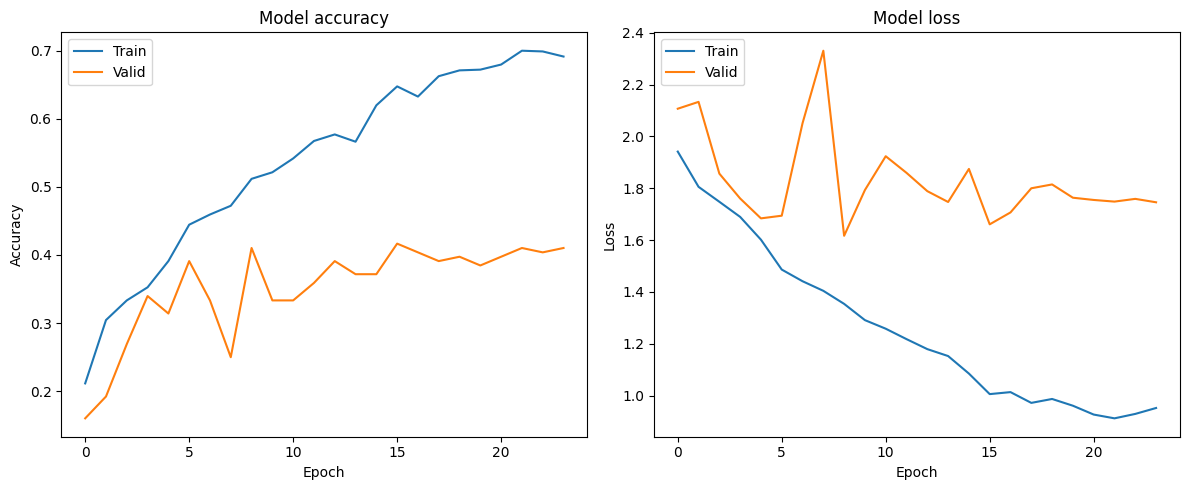


Training complete. The best model has been saved as 'best_model.keras'.


In [22]:
#Step 7: Plot Training History
print("\nPlotting training history...")
plot_history(history_refined)
print("\nTraining complete. The best model has been saved as 'best_model.keras'.")

In [23]:
#: Evaluate the Model on the Test Set ---
try:
    ref_model = tf.keras.models.load_model('best_refined_model.keras')
except (IOError, ImportError) as e:
    print("Error: Could not load the model 'best_refined_model.keras'.")
    print("Please ensure the model was saved correctly in Phase 3.")
    print(f"Details: {e}")
    exit()
print("\nEvaluating the semplified model performance on the test set...")
loss, accuracy = ref_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")


Evaluating the semplified model performance on the test set...
Test Accuracy: 51.28%
Test Loss: 1.2691


In [36]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# --- 1. Load Pre-split Augmented RAVDESS Data ---
print("Loading pre-split augmented RAVDESS data...")
data_dir_ravdess = "aug_processed_data"
X_train_ravdess = np.load(os.path.join(data_dir_ravdess, 'X_train.npy'))
y_train_ravdess = np.load(os.path.join(data_dir_ravdess, 'y_train.npy'))
X_val_ravdess = np.load(os.path.join(data_dir_ravdess, 'X_valid.npy'))
y_val_ravdess = np.load(os.path.join(data_dir_ravdess, 'y_valid.npy'))
X_test_ravdess = np.load(os.path.join(data_dir_ravdess, 'X_test.npy'))
y_test_ravdess = np.load(os.path.join(data_dir_ravdess, 'y_test.npy'))
label_classes_ravdess_8 = np.load(os.path.join(data_dir_ravdess, 'label_encoder.npy'), allow_pickle=True)

# This assumes X_savee and y_savee lists are available from the previous step
print(f"Loaded {len(X_train_ravdess)} RAVDESS training samples.")
print(f"Loaded {len(X_savee)} SAVEE samples.")

# --- 2. Filter 'calm' Emotion from RAVDESS Sets ---
print("\nFiltering 'calm' emotion to align datasets...")
calm_index = np.where(label_classes_ravdess_8 == 'calm')[0][0]

# Function to filter a dataset
def filter_calm_emotion(X, y_one_hot, calm_idx):
    y_labels = np.argmax(y_one_hot, axis=1)
    non_calm_indices = np.where(y_labels != calm_idx)[0]
    
    X_filtered = X[non_calm_indices]
    y_filtered_one_hot = np.delete(y_one_hot[non_calm_indices], calm_idx, axis=1)
    
    return X_filtered, y_filtered_one_hot

X_train_ravdess_filt, y_train_ravdess_filt = filter_calm_emotion(X_train_ravdess, y_train_ravdess, calm_index)
X_val_ravdess_filt, y_val_ravdess_filt = filter_calm_emotion(X_val_ravdess, y_val_ravdess, calm_index)
X_test_ravdess_filt, y_test_ravdess_filt = filter_calm_emotion(X_test_ravdess, y_test_ravdess, calm_index)

# Create the new 7-emotion label encoder
label_classes_7 = np.delete(label_classes_ravdess_8, calm_index)
print(f"Datasets aligned to {len(label_classes_7)} classes: {label_classes_7}")


# --- 3. Process and Split SAVEE Data by Speaker ---
print("\nProcessing and splitting SAVEE data by speaker...")
savee_speakers = [os.path.basename(f).split('_')[0] for f in all_files]
savee_df = pd.DataFrame({'features': X_savee, 'labels': y_savee, 'speaker': savee_speakers})

# Define speaker split for SAVEE's 4 speakers
train_speakers_savee = ['DC', 'JE']
val_speakers_savee = ['JK']
test_speakers_savee = ['KL']

# Encode SAVEE labels using the new 7-emotion encoder
label_encoder_7 = LabelEncoder()
label_encoder_7.classes_ = label_classes_7
y_savee_encoded = label_encoder_7.transform(savee_df['labels'])
y_savee_one_hot = to_categorical(y_savee_encoded, num_classes=7)
savee_df['encoded_labels'] = list(y_savee_one_hot)

# Split the DataFrame
train_df_savee = savee_df[savee_df['speaker'].isin(train_speakers_savee)]
val_df_savee = savee_df[savee_df['speaker'].isin(val_speakers_savee)]
test_df_savee = savee_df[savee_df['speaker'].isin(test_speakers_savee)]

# Convert to NumPy arrays
X_train_savee = np.array(train_df_savee['features'].tolist())
y_train_savee = np.array(train_df_savee['encoded_labels'].tolist())
X_val_savee = np.array(val_df_savee['features'].tolist())
y_val_savee = np.array(val_df_savee['encoded_labels'].tolist())
X_test_savee = np.array(test_df_savee['features'].tolist())
y_test_savee = np.array(test_df_savee['encoded_labels'].tolist())


# --- 4. Concatenate Final Datasets ---
print("\nCombining RAVDESS and SAVEE sets...")
X_train_final = np.concatenate((X_train_ravdess_filt, X_train_savee), axis=0)
y_train_final = np.concatenate((y_train_ravdess_filt, y_train_savee), axis=0)

X_val_final = np.concatenate((X_val_ravdess_filt, X_val_savee), axis=0)
y_val_final = np.concatenate((y_val_ravdess_filt, y_val_savee), axis=0)

X_test_final = np.concatenate((X_test_ravdess_filt, X_test_savee), axis=0)
y_test_final = np.concatenate((y_test_ravdess_filt, y_test_savee), axis=0)


# --- 5. Final Preparation & Verification ---
# Add channel dimension for the CNN
X_train_final = X_train_final[..., np.newaxis]
X_val_final = X_val_final[..., np.newaxis]
X_test_final = X_test_final[..., np.newaxis]

print("\n--- Final Combined Data Shapes ---")
print("Training data shape:", X_train_final.shape, y_train_final.shape)
print("Validation data shape:", X_val_final.shape, y_val_final.shape)
print("Testing data shape:", X_test_final.shape, y_test_final.shape)

Loading pre-split augmented RAVDESS data...
Loaded 3240 RAVDESS training samples.
Loaded 480 SAVEE samples.

Filtering 'calm' emotion to align datasets...
Datasets aligned to 7 classes: ['angry' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']

Processing and splitting SAVEE data by speaker...

Combining RAVDESS and SAVEE sets...

--- Final Combined Data Shapes ---
Training data shape: (3048, 40, 174, 1) (3048, 7)
Validation data shape: (276, 40, 174, 1) (276, 7)
Testing data shape: (276, 40, 174, 1) (276, 7)


In [44]:
# --- 1. Define Model Parameters ---
# (Assuming your augmented data X_train_aug, y_train_aug, etc. are loaded)
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

# --- 2. Build the Refined Model ---
print("Building the refined CNN-LSTM model with Attention...")
refined_model = build_refined_model(input_shape, num_classes)
refined_model.summary()

# --- 3. Define Callbacks for Robust Training ---
# ModelCheckpoint saves the best model found during training
checkpoint = ModelCheckpoint(
    'best_refined_model.keras',  # New filename for the improved model
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# EarlyStopping stops training if validation performance doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15, # Increased patience to work with the learning rate scheduler
    restore_best_weights=True,
    verbose=1
)

# NEW: ReduceLROnPlateau reduces the learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Reduce learning rate by a factor of 5
    patience=5, # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6, # Lower bound on the learning rate
    verbose=1
)

# --- 4. Set Training Parameters ---
epochs = 40 # Increased epochs since EarlyStopping will handle the end of training
batch_size = 32

Building the refined CNN-LSTM model with Attention...
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 40, 174, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 38, 172, 32)  320         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 38, 172, 32)  128        ['conv2d_6[0][0]']               
 rmalization)                                                                                     
                                      

In [46]:
# --- 5. Train the Model ---
print("\nStarting model training with augmented data and refined architecture...")
history_refined = refined_model.fit(
    X_train_final, y_train_final,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_final, y_val_final),
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

print("\nTraining complete. The best refined model has been saved.")


Starting model training with augmented data and refined architecture...
Epoch 1/40
111/111 [==============================] - ETA: 0s - loss: 1.8011 - accuracy: 0.3155
Epoch 1: val_accuracy improved from 0.15385 to 0.30128, saving model to best_refined_model.keras
111/111 [==============================] - 22s 200ms/step - loss: 1.8011 - accuracy: 0.3155 - val_loss: 1.8685 - val_accuracy: 0.3013 - lr: 0.0010
Epoch 2/40
111/111 [==============================] - ETA: 0s - loss: 1.6148 - accuracy: 0.3994
Epoch 2: val_accuracy did not improve from 0.30128
111/111 [==============================] - 45s 407ms/step - loss: 1.6148 - accuracy: 0.3994 - val_loss: 1.7358 - val_accuracy: 0.2885 - lr: 0.0010
Epoch 3/40
111/111 [==============================] - ETA: 0s - loss: 1.4588 - accuracy: 0.4555
Epoch 3: val_accuracy improved from 0.30128 to 0.41026, saving model to best_refined_model.keras
111/111 [==============================] - 19s 176ms/step - loss: 1.4588 - accuracy: 0.4555 - val_lo


Plotting training history...


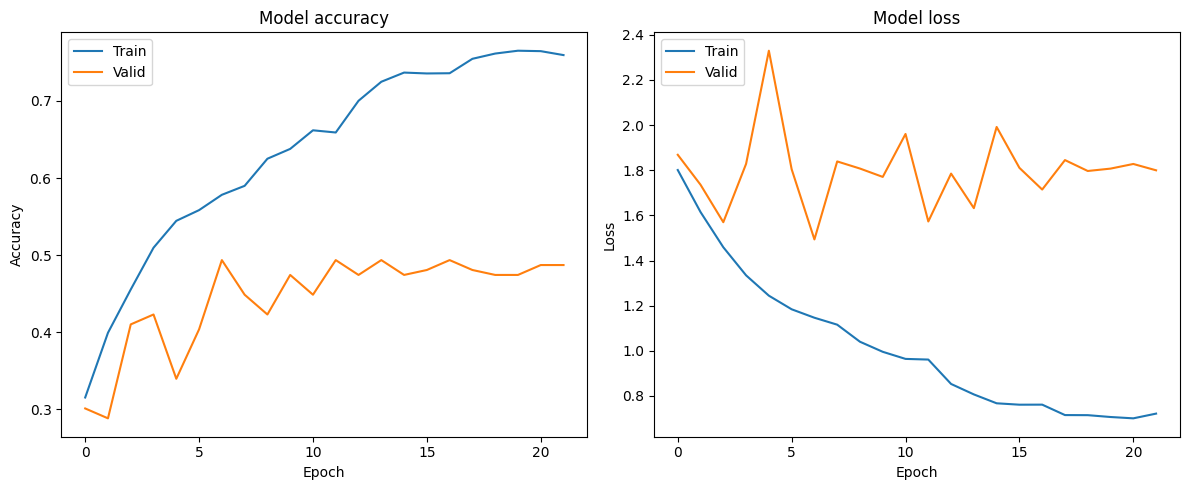


Training complete. The best model has been saved as 'best_model.keras'.


In [47]:
#Step 7: Plot Training History
print("\nPlotting training history...")
plot_history(history_refined)
print("\nTraining complete. The best model has been saved as 'best_model.keras'.")

In [48]:
#: Evaluate the Model on the Test Set ---
try:
    ref_model = tf.keras.models.load_model('best_refined_model.keras')
except (IOError, ImportError) as e:
    print("Error: Could not load the model 'best_refined_model.keras'.")
    print("Please ensure the model was saved correctly in Phase 3.")
    print(f"Details: {e}")
    exit()
print("\nEvaluating the semplified model performance on the test set...")
loss, accuracy = ref_model.evaluate(X_test_final, y_test_final, verbose=0)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")


Evaluating the semplified model performance on the test set...
Test Accuracy: 43.48%
Test Loss: 1.9867


In [41]:
import os
import glob
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import re

# --- 1. Copy Helper Functions from Your Notebook ---
MAX_PAD_LEN = 174

def extract_features(audio, sample_rate):
    """Extracts MFCCs from an audio file and pads/truncates them."""
    try:
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = MAX_PAD_LEN - mfccs.shape[1]
        if pad_width > 0:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :MAX_PAD_LEN]
    except Exception as e:
        print(f"Error processing file: {e}")
        return None
    return mfccs

def add_noise(audio, noise_factor=0.005):
    """Adds random noise to an audio signal."""
    noise = np.random.randn(len(audio))
    return (audio + noise_factor * noise).astype(type(audio[0]))

def change_pitch(audio, sample_rate, pitch_factor=2):
    """Changes the pitch of the audio."""
    return librosa.effects.pitch_shift(y=audio, sr=sample_rate, n_steps=pitch_factor)

# --- 2. Load and Filter RAVDESS Data (Same as before) ---
print("Loading and filtering pre-split augmented RAVDESS data...")
data_dir_ravdess = "aug_processed_data"
# ... (loading code is the same)
X_train_ravdess = np.load(os.path.join(data_dir_ravdess, 'X_train.npy'))
y_train_ravdess = np.load(os.path.join(data_dir_ravdess, 'y_train.npy'))
X_val_ravdess = np.load(os.path.join(data_dir_ravdess, 'X_valid.npy'))
y_val_ravdess = np.load(os.path.join(data_dir_ravdess, 'y_valid.npy'))
X_test_ravdess = np.load(os.path.join(data_dir_ravdess, 'X_test.npy'))
y_test_ravdess = np.load(os.path.join(data_dir_ravdess, 'y_test.npy'))
label_classes_ravdess_8 = np.load(os.path.join(data_dir_ravdess, 'label_encoder.npy'), allow_pickle=True)

calm_index = np.where(label_classes_ravdess_8 == 'calm')[0][0]

def filter_calm_emotion(X, y_one_hot, calm_idx):
    y_labels = np.argmax(y_one_hot, axis=1)
    non_calm_indices = np.where(y_labels != calm_idx)[0]
    X_filtered = X[non_calm_indices]
    y_filtered_one_hot = np.delete(y_one_hot[non_calm_indices], calm_idx, axis=1)
    return X_filtered, y_filtered_one_hot

X_train_ravdess_filt, y_train_ravdess_filt = filter_calm_emotion(X_train_ravdess, y_train_ravdess, calm_index)
X_val_ravdess_filt, y_val_ravdess_filt = filter_calm_emotion(X_val_ravdess, y_val_ravdess, calm_index)
X_test_ravdess_filt, y_test_ravdess_filt = filter_calm_emotion(X_test_ravdess, y_test_ravdess, calm_index)

label_classes_7 = np.delete(label_classes_ravdess_8, calm_index)
print(f"Datasets aligned to {len(label_classes_7)} classes: {label_classes_7}")

# --- 3. Process and Augment SAVEE Data by Speaker Split ---
print("\nProcessing and Augmenting SAVEE data...")
savee_emotions = {'a': 'angry', 'd': 'disgust', 'f': 'fearful', 'h': 'happy', 'n': 'neutral', 'sa': 'sad', 'su': 'surprised'}
savee_data_path = os.path.join("savee_data", "ALL")
all_savee_files = glob.glob(os.path.join(savee_data_path, "*.wav"))

train_speakers_savee = ['DC', 'JE']
val_speakers_savee = ['JK']
test_speakers_savee = ['KL']

X_train_savee, y_train_savee = [], []
X_val_savee, y_val_savee = [], []
X_test_savee, y_test_savee = [], []

for file_path in tqdm(all_savee_files, desc="Processing SAVEE"):
    file_name = os.path.basename(file_path)
    speaker = file_name.split('_')[0]
    emotion_code = re.match(r'([a-zA-Z]+)', file_name.split('_')[1]).group(1)
    emotion = savee_emotions.get(emotion_code)

    if not emotion:
        continue

    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    
    # Check which set this speaker belongs to
    if speaker in train_speakers_savee:
        # AUGMENT training data
        # 1. Original
        X_train_savee.append(extract_features(audio, sample_rate))
        y_train_savee.append(emotion)
        # 2. With Noise
        X_train_savee.append(extract_features(add_noise(audio), sample_rate))
        y_train_savee.append(emotion)
        # 3. With Pitch Shift
        X_train_savee.append(extract_features(change_pitch(audio, sample_rate, pitch_factor=np.random.randint(-3, 4)), sample_rate))
        y_train_savee.append(emotion)
        
    elif speaker in val_speakers_savee:
        X_val_savee.append(extract_features(audio, sample_rate))
        y_val_savee.append(emotion)
        
    elif speaker in test_speakers_savee:
        X_test_savee.append(extract_features(audio, sample_rate))
        y_test_savee.append(emotion)

# --- 4. Encode SAVEE Labels and Combine Datasets ---
label_encoder_7 = LabelEncoder()
label_encoder_7.classes_ = label_classes_7

# Encode and one-hot transform each set
y_train_savee_one_hot = to_categorical(label_encoder_7.transform(y_train_savee), num_classes=7)
y_val_savee_one_hot = to_categorical(label_encoder_7.transform(y_val_savee), num_classes=7)
y_test_savee_one_hot = to_categorical(label_encoder_7.transform(y_test_savee), num_classes=7)

# Combine RAVDESS and SAVEE sets
X_train_final = np.concatenate((X_train_ravdess_filt, np.array(X_train_savee)), axis=0)
y_train_final = np.concatenate((y_train_ravdess_filt, y_train_savee_one_hot), axis=0)
X_val_final = np.concatenate((X_val_ravdess_filt, np.array(X_val_savee)), axis=0)
y_val_final = np.concatenate((y_val_ravdess_filt, y_val_savee_one_hot), axis=0)
X_test_final = np.concatenate((X_test_ravdess_filt, np.array(X_test_savee)), axis=0)
y_test_final = np.concatenate((y_test_ravdess_filt, y_test_savee_one_hot), axis=0)

# --- 5. Final Preparation & Verification ---
X_train_final = X_train_final[..., np.newaxis]
X_val_final = X_val_final[..., np.newaxis]
X_test_final = X_test_final[..., np.newaxis]

print("\n--- Final Combined and Augmented Data Shapes ---")
print("Training data shape:", X_train_final.shape, y_train_final.shape)
print("Validation data shape:", X_val_final.shape, y_val_final.shape)
print("Testing data shape:", X_test_final.shape, y_test_final.shape)

Loading and filtering pre-split augmented RAVDESS data...
Datasets aligned to 7 classes: ['angry' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']

Processing and Augmenting SAVEE data...


Processing SAVEE: 100%|██████████| 480/480 [00:28<00:00, 16.76it/s]


--- Final Combined and Augmented Data Shapes ---
Training data shape: (3528, 40, 174, 1) (3528, 7)
Validation data shape: (276, 40, 174, 1) (276, 7)
Testing data shape: (276, 40, 174, 1) (276, 7)


### adding more data


In [52]:
import os
import glob
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import re

# --- 1. Helper Functions (from your notebook) ---
MAX_PAD_LEN = 174

def extract_features(audio, sample_rate):
    """Extracts MFCCs from an audio file and pads/truncates them."""
    try:
        # CORRECTED: Changed n_cc to n_mfcc
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        
        pad_width = MAX_PAD_LEN - mfccs.shape[1]
        if pad_width > 0:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :MAX_PAD_LEN]
            
    except Exception as e:
        print(f"Error processing file: {e}")
        return None
        
    return mfccs

def add_noise(audio, noise_factor=0.005):
    """Adds random noise to an audio signal."""
    noise = np.random.randn(len(audio))
    return (audio + noise_factor * noise).astype(type(audio[0]))

def change_pitch(audio, sample_rate, pitch_factor=2):
    """Changes the pitch of the audio."""
    return librosa.effects.pitch_shift(y=audio, sr=sample_rate, n_steps=pitch_factor)

# --- 2. Configuration for All Datasets ---
# Define the final 6 emotions we will be using
FINAL_EMOTIONS = ['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad']

# Speaker splits for speaker-independent train/validation/test sets
ravdess_actors = [f'ravdess_{i}' for i in range(1, 25)]
savee_actors = ['DC', 'JE', 'JK', 'KL']
crema_d_actors = [str(i) for i in range(1001, 1092)]

train_speakers = ravdess_actors[:18] + savee_actors[:2] + crema_d_actors[:65]
val_speakers = ravdess_actors[18:21] + savee_actors[2:3] + crema_d_actors[65:78]
test_speakers = ravdess_actors[21:] + savee_actors[3:] + crema_d_actors[78:]

# Emotion mappings for each dataset
ravdess_emotions = {'01': 'neutral', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'fearful', '07': 'disgust'}
savee_emotions = {'a': 'angry', 'd': 'disgust', 'f': 'fearful', 'h': 'happy', 'n': 'neutral', 'sa': 'sad'}
crema_d_emotions = {'ANG': 'angry', 'DIS': 'disgust', 'FEA': 'fearful', 'HAP': 'happy', 'NEU': 'neutral', 'SAD': 'sad'}

# --- 3. Main Processing and Augmentation Loop ---
X_all, y_all, speaker_all = [], [], []

In [53]:
# Process RAVDESS
print("Processing RAVDESS dataset...")
ravdess_path = "ravdess_data" 
for actor_dir in tqdm(os.listdir(ravdess_path), desc="RAVDESS"):
    actor_path = os.path.join(ravdess_path, actor_dir)
    if not os.path.isdir(actor_path): continue
    speaker_id = f"ravdess_{int(actor_dir.split('_')[1])}"
    
    for file_name in os.listdir(actor_path):
        emotion_code = file_name.split('-')[2]
        emotion = ravdess_emotions.get(emotion_code)
        if not emotion or emotion not in FINAL_EMOTIONS: continue

        file_path = os.path.join(actor_path, file_name)
        audio, sr = librosa.load(file_path, res_type='kaiser_fast')
        
        if speaker_id in train_speakers:
            # Augment training data
            X_all.extend([extract_features(audio, sr), extract_features(add_noise(audio), sr), extract_features(change_pitch(audio, sr, np.random.randint(-3,4)), sr)])
            y_all.extend([emotion] * 3)
            speaker_all.extend([speaker_id] * 3)
        else:
            # Keep validation and test data original
            X_all.append(extract_features(audio, sr))
            y_all.append(emotion)
            speaker_all.append(speaker_id)


Processing RAVDESS dataset...


RAVDESS: 100%|██████████| 24/24 [01:21<00:00,  3.40s/it]


In [54]:
# Process SAVEE
print("\nProcessing SAVEE dataset...")
savee_path = os.path.join("savee_data", "ALL")
for file_path in tqdm(glob.glob(os.path.join(savee_path, "*.wav")), desc="SAVEE"):
    file_name = os.path.basename(file_path)
    speaker_id = file_name.split('_')[0]
    emotion_code = re.match(r'([a-zA-Z]+)', file_name.split('_')[1]).group(1)
    emotion = savee_emotions.get(emotion_code)
    if not emotion or emotion not in FINAL_EMOTIONS: continue

    audio, sr = librosa.load(file_path, res_type='kaiser_fast')

    if speaker_id in train_speakers:
        X_all.extend([extract_features(audio, sr), extract_features(add_noise(audio), sr), extract_features(change_pitch(audio, sr, np.random.randint(-3,4)), sr)])
        y_all.extend([emotion] * 3)
        speaker_all.extend([speaker_id] * 3)
    else:
        X_all.append(extract_features(audio, sr))
        y_all.append(emotion)
        speaker_all.append(speaker_id)


Processing SAVEE dataset...


SAVEE: 100%|██████████| 480/480 [00:28<00:00, 16.59it/s]


In [55]:
# Process CREMA-D
print("\nProcessing CREMA-D dataset...")
crema_d_path = os.path.join("crema_d_data", "AudioWAV") # Ensure this is the correct path to your CREMA-D .wav files
for file_path in tqdm(glob.glob(os.path.join(crema_d_path, "*.wav")), desc="CREMA-D"):
    file_name = os.path.basename(file_path)
    speaker_id = file_name.split('_')[0]
    emotion_code = file_name.split('_')[2]
    emotion = crema_d_emotions.get(emotion_code)
    if not emotion or emotion not in FINAL_EMOTIONS: continue

    audio, sr = librosa.load(file_path, res_type='kaiser_fast')

    if speaker_id in train_speakers:
        X_all.extend([extract_features(audio, sr), extract_features(add_noise(audio), sr), extract_features(change_pitch(audio, sr, np.random.randint(-3,4)), sr)])
        y_all.extend([emotion] * 3)
        speaker_all.extend([speaker_id] * 3)
    else:
        X_all.append(extract_features(audio, sr))
        y_all.append(emotion)
        speaker_all.append(speaker_id)


Processing CREMA-D dataset...


CREMA-D: 100%|██████████| 7442/7442 [12:01<00:00, 10.32it/s]


In [56]:
# --- 4. Final Encoding and Splitting ---
print("\nEncoding labels and creating final splits...")
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_all)
y_one_hot = to_categorical(y_encoded)
num_classes = len(FINAL_EMOTIONS)

# Create final datasets
X_train, y_train = [], []
X_val, y_val = [], []
X_test, y_test = [], []

for i, speaker in enumerate(speaker_all):
    if speaker in train_speakers:
        X_train.append(X_all[i])
        y_train.append(y_one_hot[i])
    elif speaker in val_speakers:
        X_val.append(X_all[i])
        y_val.append(y_one_hot[i])
    else:
        X_test.append(X_all[i])
        y_test.append(y_one_hot[i])

# Convert to NumPy arrays & add channel dimension
X_train_final = np.array(X_train)[..., np.newaxis]
y_train_final = np.array(y_train)
X_val_final = np.array(X_val)[..., np.newaxis]
y_val_final = np.array(y_val)
X_test_final = np.array(X_test)[..., np.newaxis]
y_test_final = np.array(y_test)

print("\n--- Final Combined and Augmented Data Shapes ---")
print(f"Total Speakers: {len(set(speaker_all))}")
print(f"Training Speakers: {len(train_speakers)}, Validation Speakers: {len(val_speakers)}, Test Speakers: {len(test_speakers)}")
print("Training data shape:", X_train_final.shape, y_train_final.shape)
print("Validation data shape:", X_val_final.shape, y_val_final.shape)
print("Testing data shape:", X_test_final.shape, y_test_final.shape)


Encoding labels and creating final splits...

--- Final Combined and Augmented Data Shapes ---
Total Speakers: 119
Training Speakers: 85, Validation Speakers: 17, Test Speakers: 17
Training data shape: (18939, 40, 174, 1) (18939, 6)
Validation data shape: (1302, 40, 174, 1) (1302, 6)
Testing data shape: (1303, 40, 174, 1) (1303, 6)


In [58]:
# --- 1. Define Model Parameters ---
# (Assuming your augmented data X_train_aug, y_train_aug, etc. are loaded)
input_shape = X_train_final.shape[1:]
num_classes = y_train_final.shape[1]

# --- 2. Build the Refined Model ---
print("Building the refined CNN-LSTM model with Attention...")
model = build_refined_model(input_shape, num_classes)
model.summary()

# --- 3. Define Callbacks for Robust Training ---
# ModelCheckpoint saves the best model found during training
checkpoint = ModelCheckpoint(
    'best_refined_model.keras',  # New filename for the improved model
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# EarlyStopping stops training if validation performance doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15, # Increased patience to work with the learning rate scheduler
    restore_best_weights=True,
    verbose=1
)

# NEW: ReduceLROnPlateau reduces the learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Reduce learning rate by a factor of 5
    patience=5, # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6, # Lower bound on the learning rate
    verbose=1
)

# --- 4. Set Training Parameters ---
epochs = 40 # Increased epochs since EarlyStopping will handle the end of training
batch_size = 32

Building the refined CNN-LSTM model with Attention...
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 40, 174, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_12 (Conv2D)             (None, 38, 172, 32)  320         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_12 (BatchN  (None, 38, 172, 32)  128        ['conv2d_12[0][0]']              
 ormalization)                                                                                    
                                      

In [60]:
# --- 5. Train the Model ---
print("\nStarting model training with augmented data and refined architecture...")
history= model.fit(
    X_train_final, y_train_final,
    batch_size=100,
    epochs=20,
    validation_data=(X_val_final, y_val_final),
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

print("\nTraining complete. The best refined model has been saved.")


Starting model training with augmented data and refined architecture...
Epoch 1/20
190/190 [==============================] - ETA: 0s - loss: 1.3296 - accuracy: 0.4864
Epoch 1: val_accuracy improved from 0.36329 to 0.41859, saving model to best_refined_model.keras
190/190 [==============================] - 180s 949ms/step - loss: 1.3296 - accuracy: 0.4864 - val_loss: 1.5308 - val_accuracy: 0.4186 - lr: 0.0010
Epoch 2/20
190/190 [==============================] - ETA: 0s - loss: 1.2702 - accuracy: 0.5154
Epoch 2: val_accuracy improved from 0.41859 to 0.42243, saving model to best_refined_model.keras
190/190 [==============================] - 189s 994ms/step - loss: 1.2702 - accuracy: 0.5154 - val_loss: 1.5520 - val_accuracy: 0.4224 - lr: 0.0010
Epoch 3/20
190/190 [==============================] - ETA: 0s - loss: 1.2276 - accuracy: 0.5352
Epoch 3: val_accuracy improved from 0.42243 to 0.44624, saving model to best_refined_model.keras
190/190 [==============================] - 186s 981m


Plotting training history...


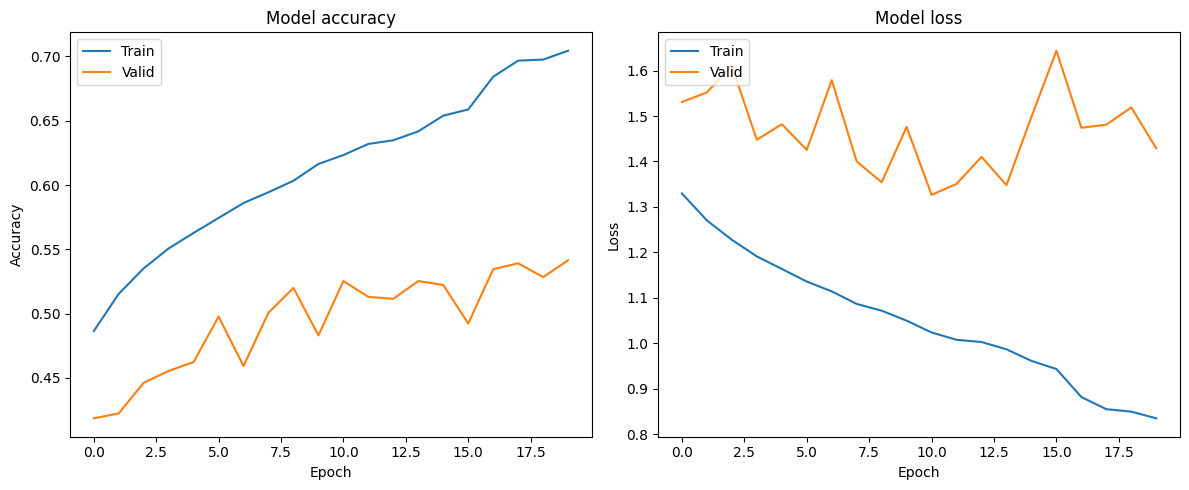


Training complete. The best model has been saved as 'best_model.keras'.


In [61]:
#Step 7: Plot Training History
print("\nPlotting training history...")
plot_history(history)
print("\nTraining complete. The best model has been saved as 'best_model.keras'.")

In [62]:
#: Evaluate the Model on the Test Set ---
try:
    ref_model = tf.keras.models.load_model('best_refined_model.keras')
except (IOError, ImportError) as e:
    print("Error: Could not load the model 'best_refined_model.keras'.")
    print("Please ensure the model was saved correctly in Phase 3.")
    print(f"Details: {e}")
    exit()
print("\nEvaluating the semplified model performance on the test set...")
loss, accuracy = ref_model.evaluate(X_test_final, y_test_final, verbose=0)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")


Evaluating the semplified model performance on the test set...
Test Accuracy: 50.50%
Test Loss: 1.6038
